# Simulations - 1 

In [1]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: MASS
Loading required package: MatchIt
Loading required package: nnet
Loading required package: numDeriv
CBPS: Covariate Balancing Propensity Score
Version: 0.10
Authors: Christian Fong <christianfong@stanford.edu>, Marc Ratkovic <ratkovic@princeton.edu>, Chad Hazlett <chazlett@ucla.edu>, Kosuke Imai <kimai@princeton.edu>

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘reshape2’

The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:quantreg’:

    untangle.specials

The following object is masked from ‘package:caret’:

    cluster

Loading req

In [2]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 800
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 10

offset = 0.1
lambda = 10

In [3]:
GetInitPars <- function(train, q=0.6) {
    index = train$reward > quantile(train$reward, q)
    rqmodel = rq(train$treatment[index] ~ train$covariates[index,] - 1, tau=.5, 
             method="lasso", weights=train$reward[index], lambda = lambda)
    return(coef(rqmodel))
}

# Проблема 1
#### dc_solution решение зависит от начального приближения

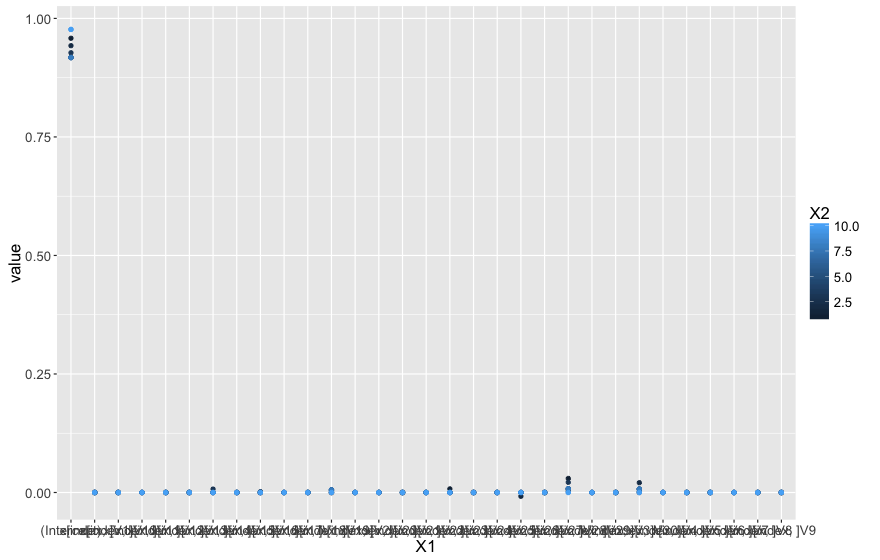

In [4]:
train <- GetSimulationData(sample.size, number.of.covariates)
quants = seq(0.05, 0.99, 0.1)
cs = list()
for (q in quants) {
    init.pars = GetInitPars(train, q=q)
    model = dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, lambda, init.pars[-1], init.pars[1])
    cs[[length(cs) + 1]] <- coef(model)
}
cs <- apply(as.data.frame(cs), 2, unlist)
colnames(cs) <- 1:NCOL(cs)
ggplot(melt(cs) , aes(X1, value))  + geom_point(aes(colour = X2)) + theme(text = element_text(size=15))

MML2PenalizedProperIters Converged after  7  iterations
MML2PenalizedProperIters Converged after  16  iterations
MML2PenalizedProperIters Converged after  5  iterations
MML2PenalizedProperIters Converged after  8  iterations
MML2PenalizedProperIters Converged after  4  iterations
MML2PenalizedProperIters Converged after  8  iterations
MML2PenalizedProperIters Converged after  10  iterations
MML2PenalizedProperIters Converged after  7  iterations
MML2PenalizedProperIters Converged after  7  iterations
MML2PenalizedProperIters Converged after  5  iterations


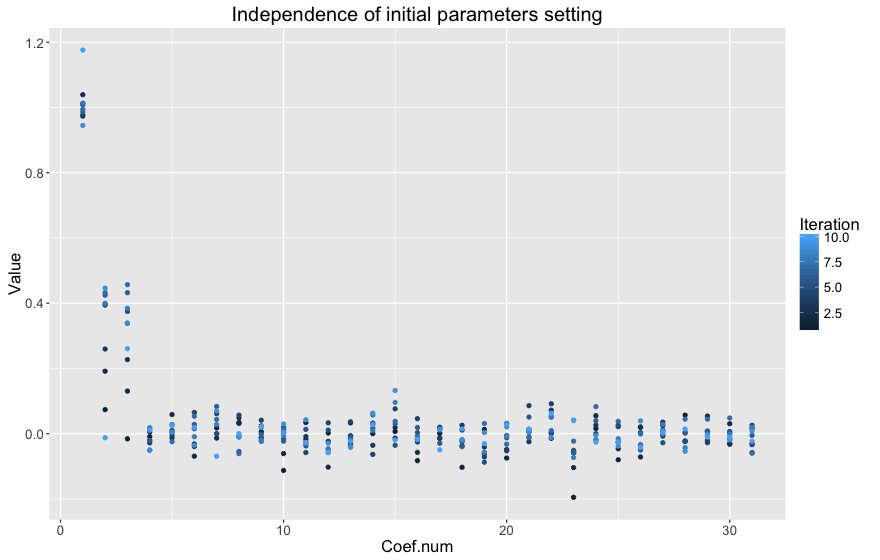

In [6]:
train <- GetSimulationData(sample.size, number.of.covariates)
quants = seq(0.05, 0.99, 0.1)
cs = list()
for (q in quants) {
  opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=GetInitPars(train, q=q), "approximation.eps"=1e-7)
  cs[[length(cs) + 1]] <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
}
cs <- apply(as.data.frame(cs), 2, unlist)
colnames(cs) <- as.factor(1:NCOL(cs))
mcs  <-  melt(cs)
names(mcs) <- c("Coef.num", "Iteration", "Value")
ggplot(mcs, aes(x=Coef.num,  y=Value))  + 
  geom_point(aes(colour = Iteration)) + 
  theme(text = element_text(size=15)) + 
  labs(title="Independence of initial parameters setting")

# Проблема 2 

In [7]:
dc_loop <- function(x,a,r,epsilon,C0, w_t, b_t){
  w = w_t + 1
  b = b_t + 1
  maxstep = 10000
  steps = 0
  #while(sum((w-w_old)^2,(b - b_old)^2)/(length(w)+1) > 0.0001 && steps < maxstep){
  while(((w-w_t)^2 + (b - b_t)^2 > 0.0001) && (steps < maxstep)){
    steps = steps + 1
    index = which(abs(a - x %*% w_t - b_t) < epsilon)
    if(length(index)<2) {break}    
    rqmodel = rq(a[index] ~ x[index,],.5,weights=r[index],method="lasso",lambda = C0)
    w_t = w 
    b_t = b
    w = rqmodel$coefficients[-1]
    b = rqmodel$coefficients[1]
  }
  pickedmodel = rqmodel
  print(steps)
  return(pickedmodel)
}


In [ ]:
global.stat <- list()


test <- GetSimulationData(test.data.sample.size, number.of.covariates)
for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size, number.of.covariates)

    init.pars = GetInitPars(train)
    init.pars.changed = GetInitPars(train, q=0.7)

    opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars.changed, "approximation.eps"=1e-7)
    pars.dca.true.MM.changed <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars)
    pars.dca.true.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    pars.owl <- GetOwlParams(train, lambda)
    pars.owl.dc_loop <- coef(dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, lambda, init.pars[-1], init.pars[1]))
    opt.decision <- c(1, 0.5, 0.5 , rep(0, length(pars.owl ) - 3))
    data.list <- list("train"=train, "test"=test)
    params.list  <- list("MM.proper.iters"=pars.dca.true.MM, 
                         "MM.proper.iters.changed"=pars.dca.true.MM.changed,
                         "OWL.dc_loop"=pars.owl.dc_loop,
                         "Ideal"=opt.decision,
                         "OWL"=pars.owl) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
}

In [ ]:
melt = reshape::melt
gl.stat.df <- apply(global.stat, 2, unlist)
vf.train <- melt(gl.stat.df[, grep("VF.*TRAIN", colnames(gl.stat.df))])
vf.test <- melt(gl.stat.df[, grep("VF.*TEST", colnames(gl.stat.df))])
obj.train <- melt(gl.stat.df[, grep("OBJ.*TRAIN", colnames(gl.stat.df))])
obj.test <- melt(gl.stat.df[, grep("OBJ.*TEST", colnames(gl.stat.df))])
q.train <- melt(gl.stat.df[, grep("Q.*TRAIN", colnames(gl.stat.df))])
q.test <- melt(gl.stat.df[, grep("Q.*TEST", colnames(gl.stat.df))])

# ggplot(q.train , aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))

# Initial approximation dependence

In [ ]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)

quants = seq(0.05, 0.99, 0.01)
stat = list()
for (q in quants) {
    pars.owl <- GetOwlParams(train, lambda, q = q)  
    s = GetMetricsForParams(list("OWL"=pars.owl), data.list, offset, PolicyFunLinearKernel, lambda)
    stat = rbind(stat, s)
}
s = data.frame(quantile=quants,  stat)

In [ ]:
plot(pars.dca.true.MM, col='red', type="l")
lines(pars.dca.true.MM.changed, col='blue')
lines(pars.owl.dc_loop, col='green')
# lines(pars.owl, col='yellow')

Warning message:
In plot.window(...): "line" is not a graphical parameterWarning message:
In plot.xy(xy, type, ...): "line" is not a graphical parameterWarning message:
In axis(side = side, at = at, labels = labels, ...): NAs introduced by coercionWarning message:
In axis(side = side, at = at, labels = labels, ...): NAs introduced by coercionWarning message:
In box(...): "line" is not a graphical parameterWarning message:
In title(...): NAs introduced by coercionWarning message:
In plot.xy(xy.coords(x, y), type = type, ...): "line" is not a graphical parameter

ERROR: Error in as.graphicsAnnot(legend): argument "legend" is missing, with no default


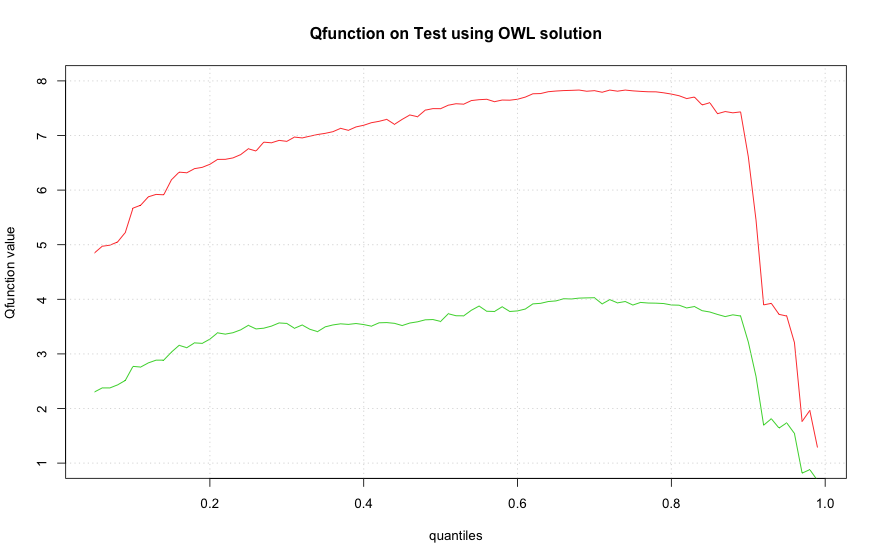

In [208]:
plot(quants, unlist(s[, "Qfun.OWL.TEST"]), type="l", ylim=c(1,8), col=2, xlab="", ylab="", line="Qfunction")
lines(quants, unlist(s[, "VF.OWL.TEST"]), type="l", col=3, line="Value Functino")
title("Qfunction on Test using OWL solution", xlab = "quantiles", ylab="Qfunction value")

grid()

Видно, что Kosorok взял квантиль, который очень близко к тому, который доставляет максимум Qfuncion.

In [213]:
s[which.max( unlist(s[, "VF.OWL.TEST"])), ]

,quantile,VF.OWL.TRAIN,OBJF.OWL.TRAIN,Qfun.OWL.TRAIN,VF.OWL.TEST,OBJF.OWL.TEST,Qfun.OWL.TEST
66,0.7,5.041106,-18.89215,7.985398,4.028885,-21.74255,7.820997


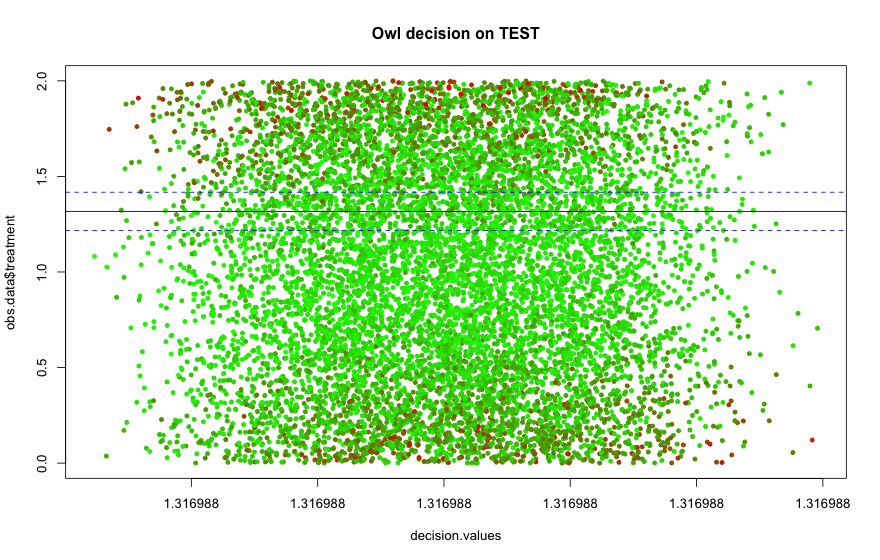

In [209]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")

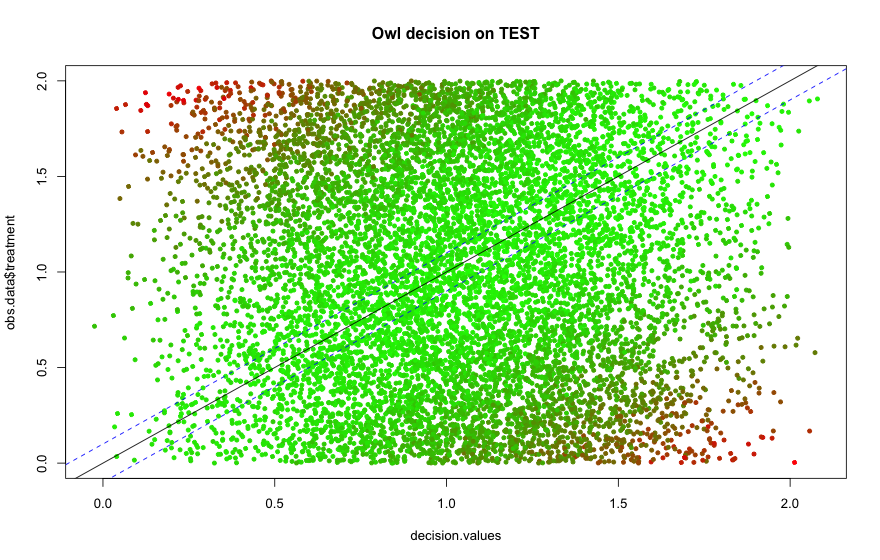

In [210]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.dca.true.MM, offset = offset, title = "Owl decision on TEST")

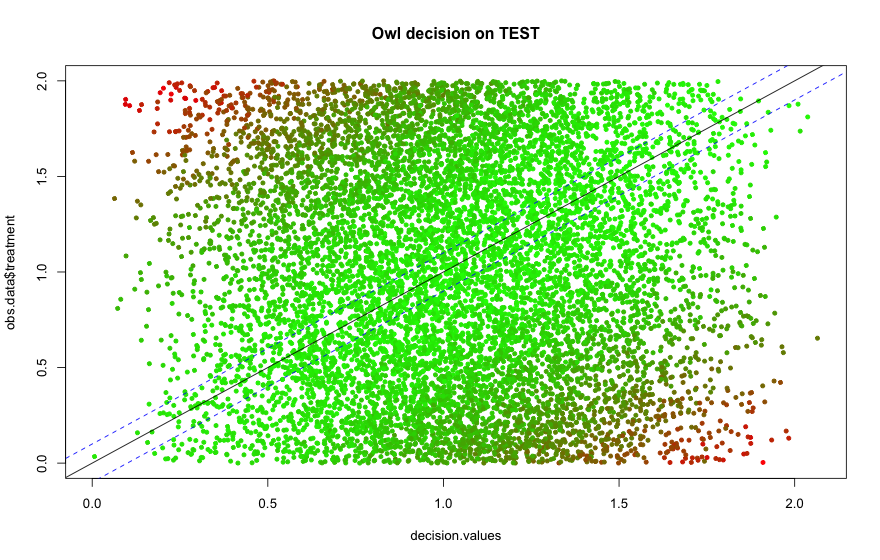

In [211]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.dca.true.MM.changed, offset = offset, title = "Owl decision on TEST")

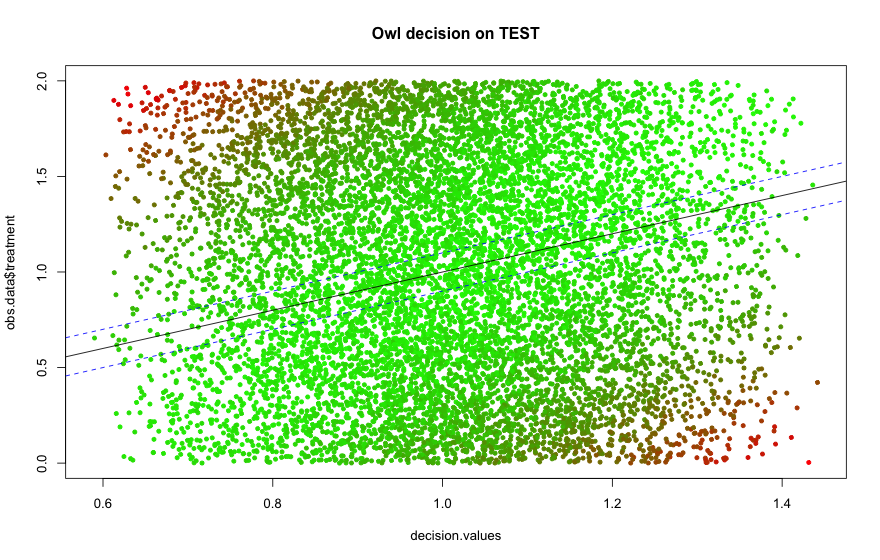

In [212]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl.dc_loop, offset = offset, title = "Owl decision on TEST")

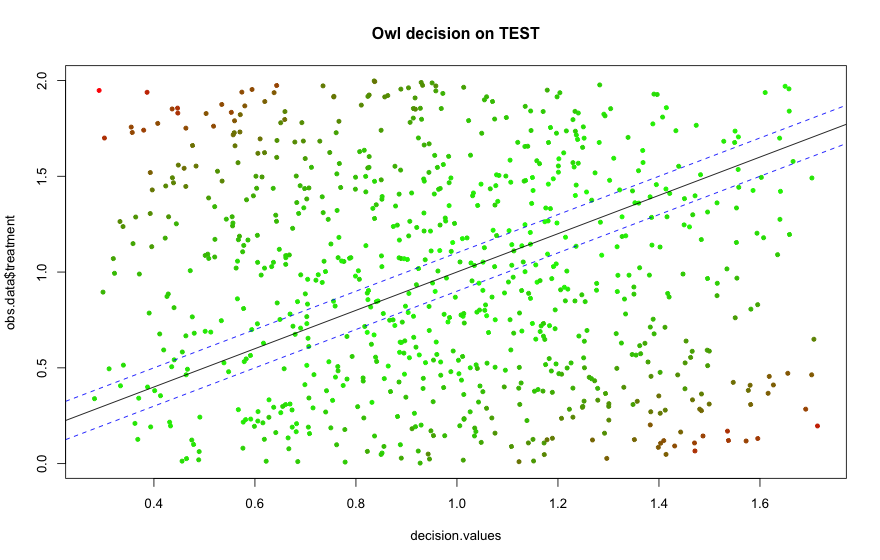

In [43]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")